# Árbol de decisión
- A01173359 - Mario Emilio Jiménez Vizcaíno
- A01656159 - Juan Sebastián Rodríguez Galarza
- A01656257 - Kevin Torres Martínez

Queremos predecir la calidad del vino rojo en base a 6 variables independientes no lineales, por lo que el árbol de decisión es el algoritmo más indicado para esta situación porque nuestro conjunto de datos de entrada está etiquetado, además de que la predicción dependerá de varias variables continuas.

Usamos el dataset [Red Wine Quality en Kaggle](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009), lo puede encontrar en la raíz de este repositorio

---
## Dependencias

Para este trabajo utilizamos:
 - `org.clojure/data.csv` para leer el csv y obtener los datos para el árbol de decisión
 - `mrcsce/decision-tree` para el procesamiento y obtener un árbol de decisión. Implementado por Miyoshi Ryota
 - `incanter` para mostrar gráficas dentro del cuaderno Jupyter
 - `clj-http` para llamar a una API que nos permite generar un SVG con GraphViz

In [1]:
(require '[clojupyter.misc.helper :as helper])
(helper/add-dependencies '[org.clojure/data.csv "0.1.2"])
(require '[clojure.data.csv :as csv])
(helper/add-dependencies '[mrcsce/decision-tree "0.1.0"])
(require '[decision-tree.core :as dt])
(helper/add-dependencies '[incanter "1.9.3"])
(use '(incanter core stats charts io))
(helper/add-dependencies '[clj-http "3.11.0"])
(require '[clj-http.client :as client])

nil

---
## Ingesta de los datos

Para empezar, leemos el archivo csv y lo guardamos en la variable `wine-quality`, declaramos la forma que tendrán los datos que guardaremos como un record `Wine`, creamos una función que nos permite pasar una fila de nuestro archivo csv a una instancia de nuestro record, y finalmente transformamos todas las filas de nuestro csv a records `Wine`

In [2]:
(def wine-quality
    (with-open [in-file (clojure.java.io/reader "winequality-red.csv")] 
        (doall (csv/read-csv in-file))))

#'user/wine-quality

In [3]:
(defrecord Wine
    [fixed_acidity volatile_acidity citrid_acid chlorides sulphates alcohol quality])

user.Wine

In [4]:
(defn vector-to-wine [v]
    (Wine.
        (Double. (nth v 0))
        (Double. (nth v 1))
        (Double. (nth v 2))
        (Double. (nth v 4))
        (Double. (nth v 9))
        (Double. (nth v 10))
        (if (< 5.5 (Integer. (nth v 11))) "buena calidad" "mala calidad")))

#'user/vector-to-wine

In [5]:
(def data (map vector-to-wine (rest wine-quality)))
(first data)

#user.Wine{:fixed_acidity 7.4, :volatile_acidity 0.7, :citrid_acid 0.0, :chlorides 0.076, :sulphates 0.56, :alcohol 9.4, :quality "mala calidad"}

---
## División del dataset

Nuestro dataset consiste en 1,599 datos, de los cuales los primeros 1,279 (80% del total) se utilizarán para entrenar el árbol de decisión, y los 320 (20% del total) restantes se utilizarán probar el modelo.

In [6]:
(def training-data (take 1279 data))
(first training-data)

#user.Wine{:fixed_acidity 7.4, :volatile_acidity 0.7, :citrid_acid 0.0, :chlorides 0.076, :sulphates 0.56, :alcohol 9.4, :quality "mala calidad"}

In [7]:
(def testing-data (drop 1279 data))
(first testing-data)

#user.Wine{:fixed_acidity 9.8, :volatile_acidity 0.3, :citrid_acid 0.39, :chlorides 0.062, :sulphates 0.57, :alcohol 11.5, :quality "buena calidad"}

---
## Generación del árbol

Como mencionamos previamente, usamos [la implementación e Miyosi Ryota](https://github.com/Miyoshi-Ryota/decision-tree-clojure) para crear nuestro árbol de decisiones. Su librería exporta dos funciones: la primera, `make-decision-tree`, recibe los datos para generar el árbol de decisiones, la altura máxima del árbol y la propiedad por la que queremos optimizar. La segunda, `predict` nos permite probar nuestro árbol con una entrada en particular, y nos regresa la predicción que generaría (la usaremos en la última parte del cuaderno).

In [8]:
(def tree
    (dt/make-decision-tree training-data 3 :quality))

#'user/tree

---
## Análisis del árbol de decisión

Usamos dos técnicas para visualizar nuestros resultados:

1. Usamos `clojure.inspector`, una librería de clojure para mostrar interactivamente la estructura de un mapa, en este caso nuestro árbol (para abrir la ventana es necesario correr la celda)
2. Usamos [quickchart.io](https://quickchart.io/) y su extensión de GraphViz para generar una representación en SVG de los nodos del árbol, y además `clojupyter.display/html` para mostrar el SVG como imagen en el cuaderno de Jupyter

In [14]:
(clojure.inspector/inspect-tree tree)

#object[javax.swing.JFrame 0x7cc8a17a "javax.swing.JFrame[frame1,0,37,400x600,invalid,layout=java.awt.BorderLayout,title=Clojure Inspector,resizable,normal,defaultCloseOperation=HIDE_ON_CLOSE,rootPane=javax.swing.JRootPane[,5,25,390x570,invalid,layout=javax.swing.JRootPane$RootLayout,alignmentX=0.0,alignmentY=0.0,border=,flags=16777673,maximumSize=,minimumSize=,preferredSize=],rootPaneCheckingEnabled=true]"]

In [13]:
(defn print-leaf [name node]
    (if (= (:predict node) "buena calidad")
        [(str name "[label=\"bueno\",color=green]")]
        [(str name "[label=\"malo\",color=red]")]))

(defn print-node [name node]
    (if (nil? (:predict node))
        (print-tree node name)
        (print-leaf name node)))

(defn print-tree [node root-name]
    (let [left-node (:left node) left-name (str root-name "l")
          right-node (:right node) right-name (str root-name "r")]
        [(str root-name "[label=\"" (:feature node) "\"]")
         (str root-name "->" left-name "[label=\" > " (:threshold node) "\"]")
         (str root-name "->" right-name "[label=\" < " (:threshold node) "\"]")
         (print-node left-name left-node)
         (print-node right-name right-node)]))

(defn fetch-quickchart [graph]
    (client/get (str "https://quickchart.io/graphviz?graph=digraph{" graph "}")))

(->>
    tree
    (print-node "r")
    flatten
    (clojure.string/join ";")
    fetch-quickchart
    :body
    clojupyter.display/html)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: %0 Pages: 1 -->
 
 
 %0 
 
<!-- r -->
 
 r 
 
 :alcohol 
 
<!-- rl -->
 
 rl 
 
 :alcohol 
 
<!-- r->rl -->
 
 r->rl 
 
 
 > 9.8 
 
<!-- rr -->
 
 rr 
 
 :sulphates 
 
<!-- r->rr -->
 
 r->rr 
 
 
 < 9.8 
 
<!-- rll -->
 
 rll 
 
 :volatile_acidity 
 
<!-- rl->rll -->
 
 rl->rll 
 
 
 > 11.2 
 
<!-- rlr -->
 
 rlr 
 
 :sulphates 
 
<!-- rl->rlr -->
 
 rl->rlr 
 
 
 < 11.2 
 
<!-- rrl -->
 
 rrl 
 
 :fixed_acidity 
 
<!-- rr->rrl -->
 
 rr->rrl 
 
 
 > 0.57 
 
<!-- rrr -->
 
 rrr 
 
 :chlorides 
 
<!-- rr->rrr -->
 
 rr->rrr 
 
 
 < 0.57 
 
<!-- rlll -->
 
 rlll 
 
 malo 
 
<!-- rll->rlll -->
 
 rll->rlll 
 
 
 > 0.76 
 
<!-- rllr -->
 
 rllr 
 
 bueno 
 
<!-- rll->rllr -->
 
 rll->rllr 
 
 
 < 0.76 
 
<!-- rlrl -->
 
 rlrl 
 
 bueno 
 
<!-- rlr->rlrl -->
 
 rlr->rlrl 
 
 
 > 0.54 
 
<!-- rlrr -->
 
 rlrr 
 
 malo 
 
<!-- rlr->rlrr -->
 
 rlr->rlrr 
 
 
 < 0.54 
 
<!-- rrll -->
 
 rrll 
 
 bueno 
 
<!-- rrl->rrll -->
 
 rrl->rrll 
 
 
 > 10.7 
 
<!-- rrlr -->
 
 rrlr 
 
 malo 
 
<!-- rrl->rrlr -->
 
 rrl->rrlr 
 
 
 < 10.7 
 
<!-- rrrl -->
 
 rrrl 
 
 malo 
 
<!-- rrr->rrrl -->
 
 rrr->rrrl 
 
 
 > 0.079 
 
<!-- rrrr -->
 
 rrrr 
 
 malo 
 
<!-- rrr->rrrr -->
 
 rrr->rrrr 
 
 
 < 0.079

---
## Validación de resultados

Finalmente, podemos probar nuestro árbol con la parte del dataset que reservamos con este propósito.

Presentamos los resultados primero contando cuántos fueron correctos (la exactitud de nuestro árbol), y después como un gráfico circular o de pastel

In [11]:
(def predicted-outcomes
    (pmap #(dt/predict tree %) testing-data))

(def real-outcomes
    (map #(:quality %) testing-data))

(def tests
    (-> (fn [p r] (cond
            (= p r) :true
            (= p "buena calidad") :falsePos
            :else :falseNeg))
        (map predicted-outcomes real-outcomes)
        frequencies))

(defn calc-percentage [n total]
    (->>
        (/ n total)
        (* 100.0)
        (format "%.2f")))

(let [num-total (count testing-data)
      num-correct (:true tests)
      perc-correct (calc-percentage num-correct num-total)
      num-incorrect (+ (:falsePos tests) (:falseNeg tests))
      perc-incorrect (calc-percentage num-incorrect num-total)]
    (println (str "Total: " num-total))
    (println (str "Conteo de correctas: " num-correct " (" perc-correct "%)"))
    (println (str "Conteo de incorrectas: " num-incorrect " (" perc-incorrect "%)")))

Total: 320
Conteo de correctas: 228 (71.25%)
Conteo de incorrectas: 92 (28.75%)


nil

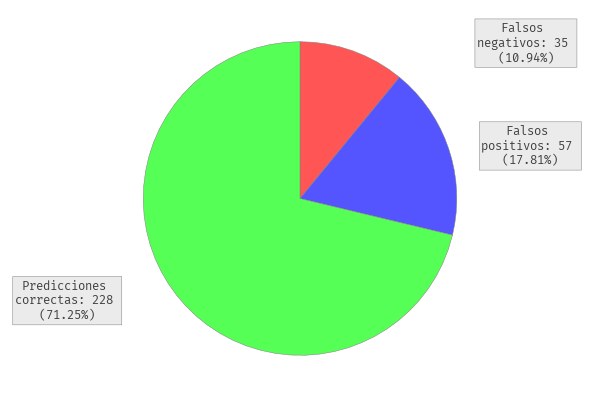

In [12]:
(def title-names
    {:true "Predicciones correctas"
     :falsePos "Falsos positivos"
     :falseNeg "Falsos negativos"})

(def titles
    (->> tests
        (into '())
        (map (partial replace title-names))
        (map #(str (first %) ": " (second %) " (" (calc-percentage (second %) (count testing-data)) "%)"))))

(def values
    (map second (into '() tests)))

(-> (pie-chart titles values)
    (.createBufferedImage  600 400))

---